# GitHub NLP Project
### Corey Solitaire and Angel Gomez
#### 10.23.2020

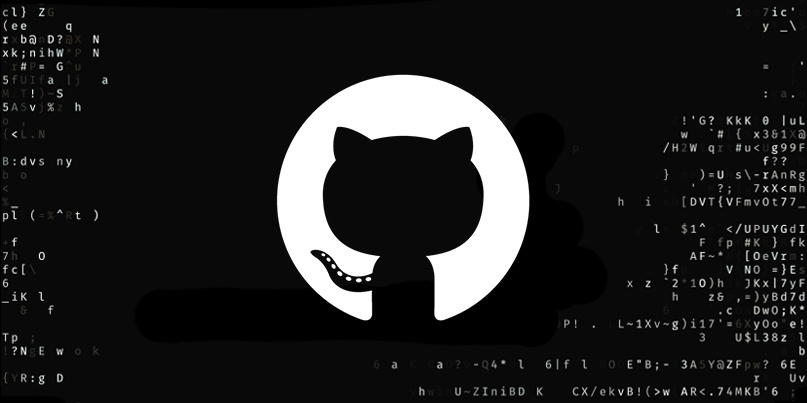

<div class="alert alert-block alert-info"><b></b></div>

## Executive Summary:
***

#### Project Summary:
*text*

#### Background:
*text*

#### Process:
*text*

#### Results:
*text*

#### Conclusion:
*text*

#### Recomendations:
*text*

<div class="alert alert-block alert-info"><b></b></div>

***
## Project Goals:
***

### 1. Build a web scraper that extracts the contents of 100 GitHub repository README.md texts as well as the            primary language of the repos.   
   
   
### 2. Use this data to build a classification model to predict the primary languae of the repository
      
      
### 3. Develop a function that will take in the text of a README file, and use that data to predict the                                programming language   
***

<div class="alert alert-block alert-info"><b></b></div>

## Work Flow:

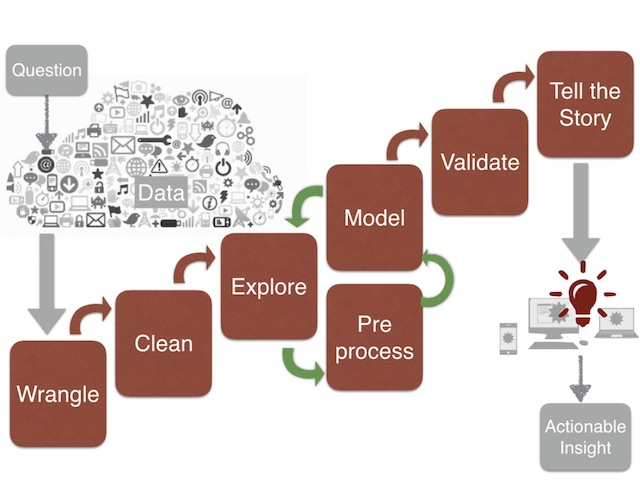

<div class="alert alert-block alert-info"><b></b></div>

## Imports
***

In [41]:
#from string import digits
import acquire
import prepare
#import requests
#from requests import get
#from bs4 import BeautifulSoup
#import os
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns


import itertools
import re
import unicodedata
import nltk

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier

#from nltk.tokenize.toktok import ToktokTokenizer
#from nltk.corpus import stopwords
from wordcloud import WordCloud

from matplotlib.pyplot import figure

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)



<div class="alert alert-block alert-info"><b></b></div>

## Data Acqusition

<div class="alert alert-block alert-info"><b></b></div>

### Web-Scraping GitHub with BeautifulSoup
***

#### 1. Identify HTML target feature using BeautifulSoup

   `Repo README.md text` - soup.select('article', class_="markdown-body entry-content container-lg")[0].text

   `Repo primary language` - soup.select('li.d-inline:nth-child(1) > a:nth-child(1)')[0].text

#### 2. Code extraction functions used to create corpus
      
     - def get_soup()   
       - This function takes in a url, parses the HTML and returns a BeautifulSoup object   

     - def get_readme_articles()   
       - This function takes in a list of urls and returns a JSON object

     - def get_urls()   
       - This function returns a list of urls that can be read in the get_readme_articles() function

     - def get_repos()   
       - This function scrapes and returns a list of repo urls from search results

### Explaination:

Using the python library BeautifulSoup the README.md text of 105 GitHub repositories were scraped. We decided to 
focus exclusivly on repositories where the `pirmary language was either Javascript or Python and the README.md was atleast 30 characters in length`. While a function that scrapes the GitHub reposity search page to return lists of reposity urls is in production, this project was conducted using repository url's collected manually.  This process consisted of a search of all GitHub user repos and added urls that fit search requirments untill 105 samples were collected.  Samples were stored in the get_urls() function and passed to get_readme_artciles() to create our reserch corpus.  
***

<div class="alert alert-block alert-info"><b></b></div>

## Data Preparation

<div class="alert alert-block alert-info"><b></b></div>

### Clean Data (prepare.py)

In [2]:
def clean_data(df): 
    # Formatt title, makes it easier to read
    df['title'] = df.title.apply(basic_clean)
    df['title'] = df.title.apply(tokenize)
    df['title'] = df.title.apply(lemmatize)
    # Formatts language makes it easier to read
    df['language'] = df.language.apply(basic_clean)
    df['language'] = df.language.apply(tokenize)
    df['language'] = df.language.apply(lemmatize)
    remove_digits = str.maketrans('', '', digits)
    df['language'] = df['language'].str.translate(remove_digits)
    df['language'] = df['language'].str.strip()
    # Formatts repo contents to make them easier to read
    df['text_cleaned'] = df.content.apply(basic_clean)
    df['text_tokenized'] = df.text_cleaned.apply(tokenize)
    df['text_lemmatized'] = df.text_tokenized.apply(lemmatize)
    df['text_filtered'] = df.text_lemmatized.apply(remove_stopwords)
    # Add column with list of words
    words = [re.sub(r'([^a-z0-9\s]|\s.\s)', '', doc).split() for doc in df.text_filtered]
    df = pd.concat([df, pd.DataFrame({'words': words})], axis=1)
    # Adds colum with lenght of word list
    df['doc_length'] = [len(wordlist) for wordlist in df.words]
    return df

### Explaination:

**clean_data( ):** This function takes in a df and `applies several functions to the title, language, and text colums` to prepare the data for exploration. This function also creates a new column with a list of words associated with each document and a new column with the lenght of each document.     

**basic_clean( ):** This function converts text in to ascii to remove special characters, then converts back in to utf-8.

**tokenize( ):** This function takes in a string and returns that string broken up in to a list of individual words.

**lemmatize( ):** This function takes in string for and returns a string with words simplifed to dictionary roots.
***

<div class="alert alert-block alert-info"><b></b></div>

## Data Exploration


**1. What are the most common words in READMEs?**    
**2. What does the distribution of IDFs look like for the most common words?**    
**3. Does the length of the README vary by programming language?**    
**4. Do different programming languages use a different number of unique words?**    


<div class="alert alert-block alert-info"><b></b></div>

#### Import split dataframes (train, validate, test)

In [3]:
urls = acquire.get_urls()
df = acquire.get_readme_articles(urls=urls, cached=True)
df = prepare.clean_data(df)
train, validate, test = prepare.train_validate_test(df)
train.shape, validate.shape, test.shape

((63, 4), (21, 4), (21, 4))

#### Visual Breakdown of Data

In [4]:
# Lets see what we are playing with
print(train.language.value_counts())
print(validate.language.value_counts())
print(test.language.value_counts())
train.head()

javascript    34
python        29
Name: language, dtype: int64
javascript    12
python         9
Name: language, dtype: int64
javascript    12
python         9
Name: language, dtype: int64


,language,text_filtered,words,doc_length
52,python,introduction reposado set tool written python ...,"[introduction, reposado, set, tool, written, p...",224
90,javascript,flowcoveragereport flowcoveragereport node com...,"[flowcoveragereport, flowcoveragereport, node,...",824
91,javascript,react native storybook content repo wa moved s...,"[react, native, storybook, content, repo, wa, ...",32
11,python,sqlalchemy python sql toolkit object relationa...,"[sqlalchemy, python, sql, toolkit, object, rel...",431
70,python,visual studio documentation welcome repo conta...,"[visual, studio, documentation, welcome, repo,...",94


<div class="alert alert-block alert-info"><b></b></div>

### Question #1. What are the most common words in READMEs?
***

In [5]:
# Create Corpus
javascript_words = ' '.join(train[train.language =='javascript'].text_filtered)
python_words = ' '.join(train[train.language =='python'].text_filtered)
all_words = ' '.join(train.text_filtered)
javascript_words = re.sub(r'\s.\s', '', javascript_words)
python_words = re.sub(r'\s.\s', '', python_words)
all_words = re.sub(r'\s.\s', '', all_words)

# Explore corpus
javascript_freq = pd.Series(javascript_words.split()).value_counts()
python_freq = pd.Series(python_words.split()).value_counts()
all_freq = pd.Series(all_words.split()).value_counts()
word_counts = (pd.concat([all_freq, javascript_freq, python_freq], axis=1, sort=True)
               .set_axis(['all', 'javascript', 'python'], axis=1, inplace=False)
               .fillna(0)
               .apply(lambda s: s.astype(int))
              )


# How often to words occur across repos
word_counts.sort_values(by='all', ascending=False).head(10)

,all,javascript,python
pod,434,434,0
new,162,113,49
command,161,78,83
see,159,106,53
name,156,110,46
option,148,109,39
label,148,136,12
node,140,135,5
code,139,62,77
container,136,136,0


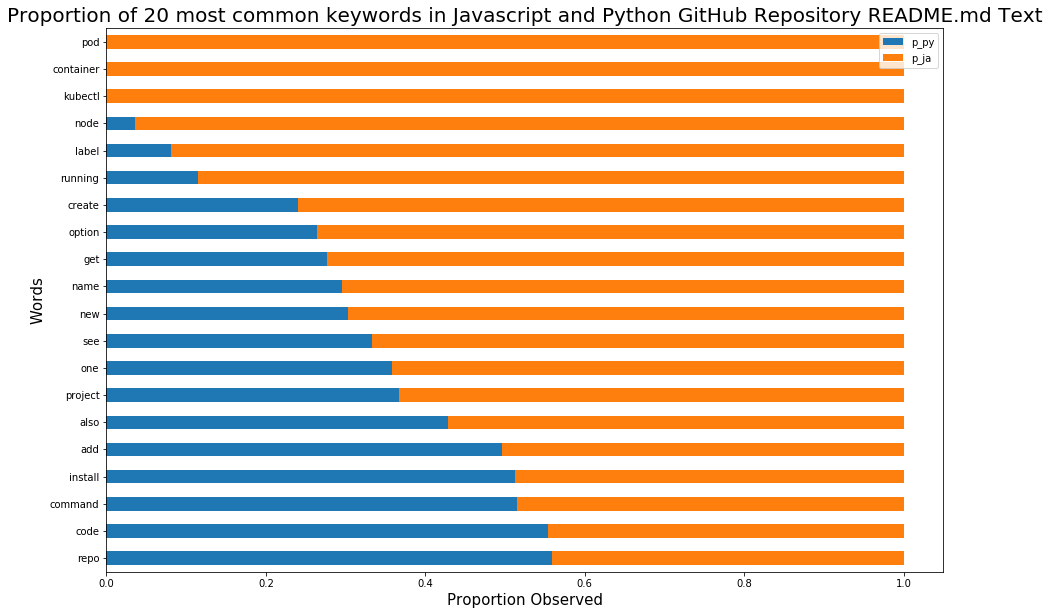

In [6]:
# visualize the percentage of the term in javascript vs. python
(word_counts.assign(p_py = word_counts.python/word_counts['all'], 
                   p_ja = word_counts.javascript/word_counts['all'])
 .sort_values(by='all')[['p_py', 'p_ja']]
 .tail(20)
 .sort_values('p_ja')
 .plot.barh(stacked=True, figsize=(15, 10))
)
plt.xlabel('Proportion Observed', fontsize=15)
plt.ylabel('Words', fontsize=15)
plt.title("Proportion of 20 most common keywords in Javascript and Python GitHub Repository README.md Text", fontsize = 20)
plt.show()

**Takeaway:**
`High proportion of most popular words are shared between repositories`
***

***Are there words that are specific only to python repositories?***

In [7]:
# Any words specific only to python and never in javascript?
word_counts[word_counts.javascript == 0].sort_values(by='python', ascending=False).head(10)

,all,javascript,python
model,104,0,104
layer,84,0,84
ggshield,59,0,59
deeplift,52,0,52
score,49,0,49
gita,48,0,48
emotion,38,0,38
bucket,34,0,34
ipython,31,0,31
s3cmd,31,0,31


**Takeaway:**
`These words would make good features to help distinguish between repositories`
***

***Are there words that are common between repositories?***

In [8]:
#code = word_counts[word_counts.javascript == word_counts.python].sort_values(by='python', ascending=False).head(10)

'''
This line of code provided us with a list of words that were common between repositores.  
These words were added to our prepare function and removed from our corpus.  The list of 
common removed words is as follows:
'''

# ['dictionary', 'machine', 'allow', 'directory','file','use','run','using','example',
#  'state','via','generate','right','call','end','given','filename','generated','within',
#  'however','several','info','dev','necessary','linux','together','bar']

'\nThis line of code provided us with a list of words that were common between repositores.  \nThese words were added to our prepare function and removed from our corpus.  The list of \ncommon removed words is as follows:\n'

****
#### Question #1 Takeaway:

1. Top 10 Javascript words (file, option, use, npm, using, run, callback, meta, new, install)      
2. Top 10 Python words     (file, video, use, youtubed, download, git, formatt, python, run, command)    
`lots of overlap between lists`   
3. Common words, bad for modeling and removed      
('dictionary','machine','allow','directory','file','use','run','using',   
'example','state','via','generate','right','call','end','given','filename',    
'generated','within','however','several','info','dev','necessary','linux','together','bar')    

  

****

<div class="alert alert-block alert-info"><b></b></div>

### Question #2. What does the distribution of IDFs look like for the most common words?

In [9]:
# create tifidf object
tfidf = TfidfVectorizer(stop_words='english', min_df=20, 
                             ngram_range=(1,2), 
                             binary=True)
tfidf_sparse_matrix = tfidf.fit_transform(train.text_filtered)
# review common words
tfidf.vocabulary_

{'set': 37,
 'python': 33,
 'update': 42,
 'license': 20,
 'new': 26,
 'user': 44,
 'feature': 12,
 'create': 8,
 'number': 29,
 'available': 1,
 'test': 40,
 'version': 45,
 'information': 17,
 'command': 6,
 'help': 16,
 'project': 32,
 'code': 5,
 'check': 4,
 'install': 18,
 'npm': 28,
 'build': 2,
 'default': 10,
 'path': 31,
 'following': 13,
 'used': 43,
 'source': 38,
 'issue': 19,
 'ha': 15,
 'change': 3,
 'support': 39,
 'github': 14,
 'data': 9,
 'repo': 34,
 'content': 7,
 'work': 47,
 'time': 41,
 'like': 21,
 'need': 25,
 'make': 24,
 'development': 11,
 'repository': 35,
 'open': 30,
 'request': 36,
 'add': 0,
 'list': 22,
 'want': 46,
 'look': 23,
 'note': 27}

****
#### Question #2 Takeaway:

1. 1. Many of the words are overlap are found in many documents, further evidence that it may be difficult to construct a model that accuratly preicts python repositories.  
****

<div class="alert alert-block alert-info"><b></b></div>

### Question #3. Does the length of the README vary by programming language?

In [10]:
# Create df
mask = train['language'] == 'python'
python_train = train[mask]
mask = train['language'] == 'javascript'
javascript_train = train[mask]
python_train.shape, javascript_train.shape

((29, 4), (34, 4))

***
### Hypothesis Test (2 Sample T-Test)
- T-tests assumes that the continous variables are normally distributed with equivilent variance
- We need to do a quick check

In [11]:
python_train.describe()

,doc_length
count,29.000000
mean,527.482759
std,555.051196
min,5.000000
25%,123.000000
50%,261.000000
75%,712.000000
max,2109.000000


***
`Mean != Meadian: Python document length is` **NOT** `evenly distributed`
***

In [12]:
javascript_train.describe()

,doc_length
count,34.000000
mean,568.588235
std,1347.332631
min,5.000000
25%,109.250000
50%,203.500000
75%,543.250000
max,7865.000000


***
`Mean != Meadian: Javascript document length is` **NOT** `evenly distributed`
***

#### Visualized Distributions

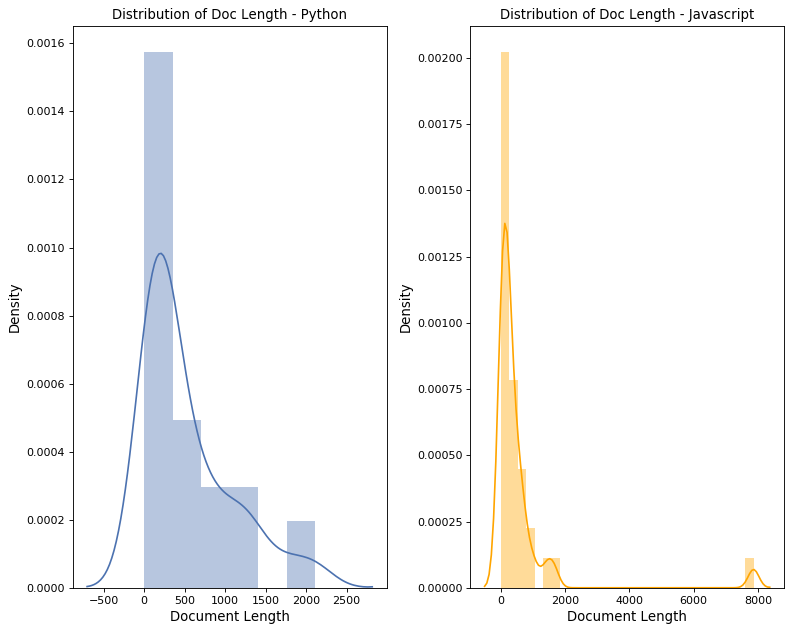

In [13]:
figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')

plt.subplot(121)
sns.set_color_codes()
sns.distplot(python_train.doc_length, color ='b')
plt.title('Distribution of Doc Length - Python')
plt.xlabel('Document Length', fontsize=12)
plt.ylabel('Density', fontsize=12)

plt.subplot(122)
sns.set_color_codes()
sns.distplot(javascript_train.doc_length, color = 'orange')
plt.title('Distribution of Doc Length - Javascript')
plt.xlabel('Document Length', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.tight_layout()
plt.show()


#### Check the Variance

In [14]:
# Variance (2 Sample T-Test)
pvar = round(python_train.doc_length.var(),2)
jvar = round(javascript_train.doc_length.var(),2)
print(f'The variance observed in the text length of Python Repositories = {pvar}')
print(f'The variance observed in the text length of Javascript Repositories = {jvar}')

The variance observed in the text length of Python Repositories = 308081.83
The variance observed in the text length of Javascript Repositories = 1815305.22


***
**Python Variance != Javascript Variance:** 
- `equil_var = False` *needs to be added to function call*
***

#### Hypothesis Test

*Null:* There is no difference in text length between Python and Javascript README.md text

*Alternate:* There is a statistically significant difference in text length between Python and Javascript README.md text

In [15]:
# 95% Confidence Interval
alpha = 0.05

In [16]:
null = 'there is no difference in text length between Python and Javascript README.md text'
t, p = stats.ttest_ind(python_train.doc_length , javascript_train.doc_length, equal_var =False)

print(f't = {t:.3f}')
print(f'p = {p:.3f}')
print("is p < alpha? ", p < alpha)
print("is t > 0? ", t > 0)
if p > alpha:
    print(f"We fail to reject that {null}")
elif t < 0:
    print(f"We fail to reject that {null}")
else:
    print(f"WE REJECT that {null}")


t = -0.162
p = 0.872
is p < alpha?  False
is t > 0?  False
We fail to reject that there is no difference in text length between Python and Javascript README.md text


****
#### Question #3 Takeaway:

1. While there intitially was a statistically significant difference between repository text length, this relationshp disapeared when words were removed from the corpus.

2.  There is now **NO** statistically significant difference between repository text length.

****

<div class="alert alert-block alert-info"><b></b></div>

### Question #4. Do different programming languages use a different number of unique words?

In [17]:
# Create list of word lists(python_train)
pwords = [re.sub(r'([^a-z0-9\s]|\s.\s)', '', doc).split() for doc in python_train.text_filtered]
# Combine those lists in to a single list
pwords = list(itertools.chain.from_iterable(pwords))

# Create list of word lists(javascript_train)
jwords = [re.sub(r'([^a-z0-9\s]|\s.\s)', '', doc).split() for doc in javascript_train.text_filtered]

# Combine those lists in to a single list
jwords = list(itertools.chain.from_iterable(jwords))

# Returns words unique to python
unique_pwords = list(set(pwords) - set(jwords))

# Returns words unique to javascript
unique_jwords = list(set(jwords) - set(pwords))

print(f'There are {len(unique_pwords)} words unique to Python GitHub README.md texts.')
print(f'There are {len(unique_jwords)} words unique to Javascript GitHub README.md texts.')

There are 3140 words unique to Python GitHub README.md texts.
There are 2862 words unique to Javascript GitHub README.md texts.


****
#### Question #4 Takeaway:

1. There appear to be 300 more words unique to python repositories.
2. This observation makes sense.  Even though there is not a statistically significant difference between the text repository texts, the python repositorys are longer on average.  


****

<div class="alert alert-block alert-info"><b></b></div>

## Modeling
***

- 2 Rounds:
   1. Standard hyperperamaters
   2. Increased min_df (Increase to 30)
      - Try of offset the lack of frequent python words.  Require the words be found more often on the page


- 1 Feature: `text_filtered`
   

- Target Variable: `language`


- Create Bag of Words and TF-IDF feature extraction tools


- Baseline performance is 54% (Javascript)

<div class="alert alert-block alert-info"><b></b></div>

In [18]:
# Import some clean data for modeling
urls = acquire.get_urls()
df = acquire.get_readme_articles(urls=urls, cached=True)
df = prepare.clean_data(df)
train, validate, test = prepare.train_validate_test(df)
train.shape, validate.shape, test.shape

((63, 4), (21, 4), (21, 4))

In [19]:
train.head()

,language,text_filtered,words,doc_length
52,python,introduction reposado set tool written python ...,"[introduction, reposado, set, tool, written, p...",224
90,javascript,flowcoveragereport flowcoveragereport node com...,"[flowcoveragereport, flowcoveragereport, node,...",824
91,javascript,react native storybook content repo wa moved s...,"[react, native, storybook, content, repo, wa, ...",32
11,python,sqlalchemy python sql toolkit object relationa...,"[sqlalchemy, python, sql, toolkit, object, rel...",431
70,python,visual studio documentation welcome repo conta...,"[visual, studio, documentation, welcome, repo,...",94


#### Estabolish Basline

In [20]:
# Baseline
train.language.value_counts()

javascript    34
python        29
Name: language, dtype: int64

In [21]:
# Most Common Language is Javascript, so we will use that as baseline
# Baseline prediction javascript
baseline = round(len(train[train.language == 'javascript']) / len(train), 2)
baseline

0.54

<div class="alert alert-block alert-info"><b></b></div>

## Create Features
***

#### Create Standard Bag of Words Feature

In [22]:
# Create CountVectorizer, which create bag-of-words model feature
vectorizer = CountVectorizer(stop_words='english', 
                             min_df=20, 
                             ngram_range=(1,2), 
                             binary=True)

# Learn vocabulary in sentences 
vectorizer.fit(train.text_filtered)

CountVectorizer(analyzer='word', binary=True, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=20,
                ngram_range=(1, 2), preprocessor=None, stop_words='english',
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

#### Create *Modified* Bag of Words Feature

In [23]:
# Create CountVectorizer, which create bag-of-words model feature
vectorizer_m = CountVectorizer(stop_words='english', 
                             min_df=30, 
                             ngram_range=(1,2), 
                             binary=True)

# Learn vocabulary in sentences 
vectorizer_m.fit(train.text_filtered)

CountVectorizer(analyzer='word', binary=True, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=30,
                ngram_range=(1, 2), preprocessor=None, stop_words='english',
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

#### Create Standard TF-IDF Feature

In [24]:
# Create CountVectorizer, which create TF-IDF model feature
tfidf = TfidfVectorizer(stop_words='english', min_df=20, 
                             ngram_range=(1,2), 
                             binary=True)

# Learn vocabulary in sentences
tfidf.fit(train.text_filtered)

TfidfVectorizer(analyzer='word', binary=True, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=20, ngram_range=(1, 2), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words='english', strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

#### Create *Modified* TF-IDF Feature

In [25]:
# Create CountVectorizer, which create TF-IDF model feature
tfidf_m = TfidfVectorizer(stop_words='english', min_df=30, 
                             ngram_range=(1,2), 
                             binary=True)

# Learn vocabulary in sentences
tfidf_m.fit(train.text_filtered)

TfidfVectorizer(analyzer='word', binary=True, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=30, ngram_range=(1, 2), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words='english', strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

<div class="alert alert-block alert-info"><b></b></div>

## Train

<div class="alert alert-block alert-info"><b></b></div>

## Logistic Regression

#### BOW_standard

In [26]:
bow = vectorizer.transform(train.text_filtered)
X_bow_train = bow
y = train['language']

lm = LogisticRegression().fit(X_bow_train, y)
train['pred_bow'] = lm.predict(X_bow_train)

In [27]:
# Results(train)
pd.crosstab(train.language, train.pred_bow)

pred_bow,javascript,python
language,,
javascript,34,0
python,1,28


In [28]:
# classificaiton report
print(classification_report(train.language, train.pred_bow))

              precision    recall  f1-score   support

  javascript       0.97      1.00      0.99        34
      python       1.00      0.97      0.98        29

    accuracy                           0.98        63
   macro avg       0.99      0.98      0.98        63
weighted avg       0.98      0.98      0.98        63



***

#### BOW_modified

In [29]:
bow = vectorizer_m.transform(train.text_filtered)
X_bow_train_m = bow
y = train['language']

lm = LogisticRegression().fit(X_bow_train_m, y)
train['pred_bow'] = lm.predict(X_bow_train_m)

In [30]:
# Results(train)
pd.crosstab(train.language, train.pred_bow)

pred_bow,javascript,python
language,,
javascript,24,10
python,16,13


In [31]:
# classificaiton report
print(classification_report(train.language, train.pred_bow))

              precision    recall  f1-score   support

  javascript       0.60      0.71      0.65        34
      python       0.57      0.45      0.50        29

    accuracy                           0.59        63
   macro avg       0.58      0.58      0.57        63
weighted avg       0.58      0.59      0.58        63



***

#### TF-IDF

In [32]:
tfidf_sparse_matrix = tfidf.transform(train.text_filtered)
X_tfidf_train = tfidf_sparse_matrix
y = train['language']

lm_tfidf = LogisticRegression().fit(X_tfidf_train, y)
train['pred_tfidf'] = lm_tfidf.predict(X_tfidf_train)

In [33]:
# Results(train)
pd.crosstab(train.language, train.pred_tfidf)

pred_tfidf,javascript,python
language,,
javascript,32,2
python,5,24


In [34]:
# classification report
print(classification_report(train.language, train.pred_tfidf))

              precision    recall  f1-score   support

  javascript       0.86      0.94      0.90        34
      python       0.92      0.83      0.87        29

    accuracy                           0.89        63
   macro avg       0.89      0.88      0.89        63
weighted avg       0.89      0.89      0.89        63



***

#### TF-IDF_modified

In [35]:
tfidf_sparse_matrix = tfidf_m.transform(train.text_filtered)
X_tfidf_train_m = tfidf_sparse_matrix
y = train['language']

lm_tfidf = LogisticRegression().fit(X_tfidf_train_m, y)
train['pred_tfidf'] = lm_tfidf.predict(X_tfidf_train_m)

In [36]:
# Results(train)
pd.crosstab(train.language, train.pred_tfidf)

pred_tfidf,javascript,python
language,,
javascript,26,8
python,20,9


In [37]:
# classification report
print(classification_report(train.language, train.pred_tfidf))

              precision    recall  f1-score   support

  javascript       0.57      0.76      0.65        34
      python       0.53      0.31      0.39        29

    accuracy                           0.56        63
   macro avg       0.55      0.54      0.52        63
weighted avg       0.55      0.56      0.53        63



## Decision Tree

### Bow

In [39]:
tree = DecisionTreeClassifier(max_depth=3, random_state=123)
tree_fit = tree.fit(X_bow_train, train.language)
train['predicted_xbow'] = tree_fit.predict(X_bow_train)

In [48]:
print('Decision Tree BOW Accuracy:',accuracy_score(train.language, train.predicted_xbow).round(2)*100, '%','\n')
print(classification_report(train.language, train.predicted_xbow))
pd.crosstab(train.language, train.predicted_xbow)

Decision Tree BOW Accuracy: 86.0 % 

              precision    recall  f1-score   support

  javascript       0.80      0.97      0.88        34
      python       0.95      0.72      0.82        29

    accuracy                           0.86        63
   macro avg       0.88      0.85      0.85        63
weighted avg       0.87      0.86      0.85        63



predicted_xbow,javascript,python
language,,
javascript,33,1
python,8,21


### TF-IDF

In [63]:
tfidf = TfidfVectorizer(stop_words='english', min_df=5, 
                                     ngram_range=(1,2), 
                                     binary=True)

tfidf_sparse_matrix = tfidf.fit_transform(train.text_filtered)
X_tfidf = tfidf_sparse_matrix
tree = DecisionTreeClassifier(max_depth=3, random_state=123)
tree_fit = tree.fit(X_tfidf, train.language)
train['predicted_tfidf'] = tree_fit.predict(X_tfidf)

In [64]:
print('Decision Tree TF-IDF Accuracy:',accuracy_score(train.language, train.predicted_tfidf).round(2)*100,'%','\n')
print(classification_report(train.language, train.predicted_tfidf))
pd.crosstab(train.language, train.predicted_tfidf)

Decision Tree TF-IDF Accuracy: 90.0 % 

              precision    recall  f1-score   support

  javascript       1.00      0.82      0.90        34
      python       0.83      1.00      0.91        29

    accuracy                           0.90        63
   macro avg       0.91      0.91      0.90        63
weighted avg       0.92      0.90      0.90        63



predicted_tfidf,javascript,python
language,,
javascript,28,6
python,0,29


***
#### Takeaway:

`1. BOW preforms better then TF-IDF on Train`   
`2. BOW modified preformed better than BOW standard`   

***

<div class="alert alert-block alert-info"><b></b></div>

## Validate

<div class="alert alert-block alert-info"><b></b></div>

## Logistic Regression

#### BOW

In [65]:
bow = vectorizer.transform(validate.text_filtered)
X_bow_validate = bow
y = validate['language']

lm = LogisticRegression().fit(X_bow_validate, y)
validate['pred_bow'] = lm.predict(X_bow_validate)

In [66]:
# Results(validate)
pd.crosstab(validate.language, validate.pred_bow)

pred_bow,javascript,python
language,,
javascript,12,0
python,1,8


In [67]:
# classificaiton report
print(classification_report(validate.language, validate.pred_bow))

              precision    recall  f1-score   support

  javascript       0.92      1.00      0.96        12
      python       1.00      0.89      0.94         9

    accuracy                           0.95        21
   macro avg       0.96      0.94      0.95        21
weighted avg       0.96      0.95      0.95        21



***

#### BOW_modified

In [68]:
bow = vectorizer_m.transform(validate.text_filtered)
X_bow_validate_m = bow
y = validate['language']

lm = LogisticRegression().fit(X_bow_validate_m, y)
validate['pred_bow'] = lm.predict(X_bow_validate_m)

In [69]:
# Results(validate)
pd.crosstab(train.language, train.pred_bow)

pred_bow,javascript,python
language,,
javascript,24,10
python,16,13


In [70]:
# classificaiton report
print(classification_report(validate.language, validate.pred_bow))

              precision    recall  f1-score   support

  javascript       0.82      0.75      0.78        12
      python       0.70      0.78      0.74         9

    accuracy                           0.76        21
   macro avg       0.76      0.76      0.76        21
weighted avg       0.77      0.76      0.76        21



***

#### TF-IDF

In [71]:
tfidf_sparse_matrix = tfidf.transform(validate.text_filtered)
X_tfidf_validate = tfidf_sparse_matrix
y = validate['language']

lm_tfidf = LogisticRegression().fit(X_tfidf_validate, y)
validate['pred_tfidf'] = lm_tfidf.predict(X_tfidf_validate)

In [72]:
# Results(validate)
pd.crosstab(validate.language, validate.pred_tfidf)

pred_tfidf,javascript,python
language,,
javascript,12,0
python,0,9


In [73]:
# classification report(validate)
print(classification_report(validate.language, validate.pred_tfidf))

              precision    recall  f1-score   support

  javascript       1.00      1.00      1.00        12
      python       1.00      1.00      1.00         9

    accuracy                           1.00        21
   macro avg       1.00      1.00      1.00        21
weighted avg       1.00      1.00      1.00        21



***

#### TD-IDF_modified

In [74]:
tfidf_sparse_matrix = tfidf_m.transform(validate.text_filtered)
X_tfidf_validate_m = tfidf_sparse_matrix
y = validate['language']

lm_tfidf = LogisticRegression().fit(X_tfidf_validate_m, y)
validate['pred_tfidf'] = lm_tfidf.predict(X_tfidf_validate_m)

In [75]:
# Results(validate)
pd.crosstab(validate.language, validate.pred_tfidf)

pred_tfidf,javascript,python
language,,
javascript,10,2
python,5,4


In [76]:
# classification report(validate)
print(classification_report(validate.language, validate.pred_tfidf))

              precision    recall  f1-score   support

  javascript       0.67      0.83      0.74        12
      python       0.67      0.44      0.53         9

    accuracy                           0.67        21
   macro avg       0.67      0.64      0.64        21
weighted avg       0.67      0.67      0.65        21



## Decision Tree

In [59]:
tfidf = TfidfVectorizer(stop_words='english', min_df=5, 
                                     ngram_range=(1,2), 
                                     binary=True)

tfidf_sparse_matrix = tfidf.fit_transform(validate.text_filtered)
X_tfidf_validate = tfidf_sparse_matrix
tree = DecisionTreeClassifier(max_depth=2, random_state=123)
tree_fit = tree.fit(X_tfidf_validate, validate.language)
validate['predicted_tfidf'] = tree_fit.predict(X_tfidf_validate)

In [60]:
print('Decision Tree TF-IDF Accuracy:',accuracy_score(validate.language, validate.predicted_tfidf).round(2)*100,'%','\n')
print(classification_report(validate.language, validate.predicted_tfidf))
pd.crosstab(validate.language, validate.predicted_tfidf)

Decision Tree TF-IDF Accuracy: 95.0 % 

              precision    recall  f1-score   support

  javascript       0.92      1.00      0.96        12
      python       1.00      0.89      0.94         9

    accuracy                           0.95        21
   macro avg       0.96      0.94      0.95        21
weighted avg       0.96      0.95      0.95        21



predicted_tfidf,javascript,python
language,,
javascript,12,0
python,1,8


***

***
#### Takeaway:

`1. BOW preforms better then TF-IDF on Train and Validate`    
`2. BOW standard preformed better than BOW modified`   
`2. BOW standard will move on to test`      
***

<div class="alert alert-block alert-info"><b></b></div>

## Test

<div class="alert alert-block alert-info"><b></b></div>

 #### BOW_standard

In [77]:
bow = vectorizer.transform(test.text_filtered)
X_bow_test = bow
y = test['language']
lm = LogisticRegression().fit(X_bow_test, y)
test['pred_bow'] = lm.predict(X_bow_test)

In [78]:
# Results(test)
results = pd.crosstab(test.language, test.pred_bow)
results

pred_bow,javascript,python
language,,
javascript,12,0
python,0,9


### TF-IDF Decision Tree

In [88]:
tfidf = TfidfVectorizer(stop_words='english', min_df=5, 
                                     ngram_range=(1,2), 
                                     binary=True)

tfidf_sparse_matrix = tfidf.fit_transform(test.text_filtered)
X_tfidf_test = tfidf_sparse_matrix
tree = DecisionTreeClassifier(max_depth=2, random_state=123)
tree_fit = tree.fit(X_tfidf_test, test.language)
test['predicted_tfidf'] = tree_fit.predict(X_tfidf_test)

In [90]:
print('Decision Tree TF-IDF Accuracy:',accuracy_score(test.language, test.predicted_tfidf).round(2)*100,'%','\n')
print(classification_report(test.language, test.predicted_tfidf))
pd.crosstab(test.language, test.predicted_tfidf)

Decision Tree TF-IDF Accuracy: 95.0 % 

              precision    recall  f1-score   support

  javascript       1.00      0.92      0.96        12
      python       0.90      1.00      0.95         9

    accuracy                           0.95        21
   macro avg       0.95      0.96      0.95        21
weighted avg       0.96      0.95      0.95        21



predicted_tfidf,javascript,python
language,,
javascript,11,1
python,0,9


#### Calculate % Improvement

In [79]:
confusion = confusion_matrix(y, test.pred_bow)
print(confusion)
#[row, column]
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]

[[12  0]
 [ 0  9]]


In [80]:
# Baseline Accuracy
print(f'Baseline accuracy of our model: {baseline}') 

Baseline accuracy of our model: 0.54


In [81]:
# Classification Accuracy: Overall, how often is the classifier correct?
model_accuracy = ((TP + TN) / float(TP + TN + FP + FN))
# use float to perform true division, not integer division
print(f"Model Accuracy on Test: {model_accuracy}")

Model Accuracy on Test: 1.0


In [82]:
# Calcuating % improvement
# First: work out the difference (increase) between the two numbers you are comparing
difference = (model_accuracy - baseline)
# Then: divide the increase by the original number and multiply the answer by 100
percent_improve = round((difference / baseline) * 100, 2)
print(f'The Percent improvement for our model is {percent_improve}%')

The Percent improvement for our model is 85.19%


<div class="alert alert-block alert-info"><b></b></div>

## Cross-Validation

1. Resapmple and apply model to larger training dataset, and test again to verify results

<div class="alert alert-block alert-info"><b></b></div>

In [83]:
#Import some clean data for modeling
urls = acquire.get_urls()
df = acquire.get_readme_articles(urls=urls, cached=True)
df = prepare.clean_data(df)

# Resample data to expand train and retest

train, test = train_test_split(df[['language', 'text_filtered','words','doc_length']], 
                                    random_state = 123,
                                    stratify=df.language, 
                                    test_size=.2)
train.shape, test.shape

((84, 4), (21, 4))

In [84]:
# Create CountVectorizer, which create bag-of-words model feature
vectorizer = CountVectorizer(stop_words='english', 
                             min_df=20, 
                             ngram_range=(1,2), 
                             binary=True)

# Learn vocabulary in sentences 
vectorizer.fit(train.text_filtered)

CountVectorizer(analyzer='word', binary=True, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=20,
                ngram_range=(1, 2), preprocessor=None, stop_words='english',
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [85]:
# Train 
bow = vectorizer.transform(train.text_filtered)
X_bow_train = bow
y = train['language']

lm = LogisticRegression().fit(X_bow_train, y)
train['pred_bow'] = lm.predict(X_bow_train)

In [86]:
# Results(train)
pd.crosstab(train.language, train.pred_bow)

pred_bow,javascript,python
language,,
javascript,46,0
python,1,37


In [87]:
# classification report(validate)
print(classification_report(train.language, train.pred_bow))

              precision    recall  f1-score   support

  javascript       0.98      1.00      0.99        46
      python       1.00      0.97      0.99        38

    accuracy                           0.99        84
   macro avg       0.99      0.99      0.99        84
weighted avg       0.99      0.99      0.99        84



In [ ]:
# Test
bow = vectorizer.transform(test.text_filtered)
X_bow_test = bow
y = test['language']
lm = LogisticRegression().fit(X_bow_test, y)
test['pred_bow'] = lm.predict(X_bow_test)

In [ ]:
# Results(train)
pd.crosstab(test.language, test.pred_bow)

In [ ]:
# classification report(validate)
print(classification_report(test.language, test.pred_bow))

<div class="alert alert-block alert-info"><b></b></div>

## Project Summary:

<div class="alert alert-block alert-info"><b></b></div>

## Exploration Summary

### 1. What are the most common words in READMEs?

- The most common words in javascript repositories include `(file, option, use, npm, using, run, callback, meta, new, install)`   


- The most common words in python repositories include `(file, video, use, youtubed, download, git, formatt, python, run, command)`   


- The 29 most common words were removed from the corpus after our inital round of modeling. 
   - These words included,`('dictionary','machine','allow','directory','file','use','run','using','example','state','via',
'generate','right','call','end','given','filename','generated','within','however','several','info','dev',
'necessary','linux','together','bar')`   

### 2. What does the distribution of IDFs look like for the most common words?

- The 29 most common words were found in over 20% of all documents.  These identified words were removed from the corpus after our inital round of modeling


### 3. Does the length of the README vary by programming language?

- 2 Tailed Hypothesis Test   
  `-Null: No difference between length of repo depending on primary language type` 
  
  
  -**Inital hypothesis test** returned t value > 0 and p value < 0.05
    - Rejection of the null, statistically significant difference exists 
  
  
  -**Test following the removal of common words** returned t values < 0 and p values > 0.05
    - Failure to reject the null, no statstically significant difference

### 4. Do different programming languages use a different number of unique words? 

- There are 3140 words unique to Python GitHub README.md texts
- There are 2862 words unique to Javascript GitHub README.md texts
- There appear to be 300 more words unique to python repositories
- `This observation makes sense. Even though there is not a statistically significant difference between the text repository texts, the python repositorys are longer on average`


<div class="alert alert-block alert-info"><b></b></div>

## Modeling Summary

### Inital Round of Modeling (Overfitting)
  - 2 Unique Selectors fit on Linear Regression Models
     - BOW + Logistic Regression
     - TF-IDF + Logistic Regression

*Model Summary*

`Model became overfit in validate and even more so in test.  Based on this overfitting 27 shared words were removed from the corpus.`
***


### Second Round of Modeling (Reduced Common Words)
  - 2 Models, standard and modified min_df hyper-paramater
  - (min_df) Hyper-paramater that ignores terms that have a document frequency strictly lower than the given threshold
  
  
**Train:**   
   - M1BOWS -   98% Accuracy
   - M2BOWM -   59% Accuracy
   - M3TFIDFS - 89% Accuracy
   - M4TFIDFM - 56% Accuracy
       
*Train Summary:*    

`1.Standard models outpreformed modified models, with M1BOW yeilding the highest level of accuracy on unseen data`

**Validate:**  
   - M1BOWS -   95% Accuracy 
   - M2BOWM -   76% Accuracy 
   - M3TFIDFS - 86% Accuracy
   - M4TFIDFM - 67% Accuracy
       
*Validate Summary*

`1.Standard models outpreformed modified models, with M1BOW yeilding the highest level of accuracy on unseen data` 
`2.Overfitting not observed with modified corpus`   
`3.M1BOW will move on to Test`   

**Test**
   - M1BOWS - 100% Accuracy

*Test Summary*   
`1.M1BOW yeilded 100% accuracy on unseen data `   
`2.Model provides` **85%** `improvement over baseline`   

***
### Third Round of Modeling (Resample and Repeat to Verify Results)
  - Resampled train in to train, test (added validate to train test set)
  - 1 Model (Standard BOW + Logistic Regression)

**Train:**   
   - M1BOWS -   99% Accuracy
       
*Train Summary:*    

`1.Model maintained preformance on resampled train data`

*** 
**Test**
   - M1BOWS - 100% Accuracy

*Test Summary*   
`1.Model maintained preformance on resample test data `  
   
***

<div class="alert alert-block alert-info"><b></b></div>

## Next Steps

**More Data**
- This dataset represented a realativly small sample of all GitHub repositories.  A more robust dataset would provide a way to evaluate model preformance over numerous trials while providing the model with a wider variety of repository README.md data.   

**New Models**
- In this project we evaluated two different feature selection tools (BOW and TF-IDF) using a single logistic regession model.  There exists the possibility that other models may lend themselves better to classifying NLP data.    

**Explore Other Languages**
- We designed our current model to classify between two primary text languages, python and javascript.  It would be interesting to explore how adding more languages affected model preformance.  By grouping all other languages together in a feature known as 'other' would we be able to get a better signal on a single language?

<div class="alert alert-block alert-info"><b></b></div>

## Function: predict_readme( )

- This function takes in GitHub url and returns a prediction of the primary laguage (python/javascript) of that reopsitory


<div class="alert alert-block alert-info"><b></b></div>